In [1]:
from ECEproj4 import *
turn = 0.01/25
from numpy import matmul as matm
import filterpy
from matplotlib import pyplot as plt
from numpy.random import uniform
from numpy.random import randn
import scipy

from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

No RLR Path
No LRL Path
[[-15. -10.]
 [-15.   5.]]
[[-100.  -10.]
 [-100.    5.]]


In [2]:
#check previous variables
#print(path.shape)    #the true path
#print(noise_path_intg.shape)    #the noisy model transition
#print(noised_path_sam1.shape)    #the noisy measurement data
#print(noisy_radar_bearing1.shape)
#print(noisy_radar_bearing2.shape)

noisy_radar1= np.zeros((200,3))
for i in range(0,200):
    noisy_radar1[i,:] = noisy_radar_bearing1[50*i,:]
    
print(noisy_radar1.shape)

noisy_radar2= np.zeros((200,3))

for i in range(0,200):
    noisy_radar2[i,:] = noisy_radar_bearing2[50*i,:]
    
print(noisy_radar2.shape)

(200, 3)
(200, 3)


In [3]:
num_particles = 10000
wght_init = 1/num_particles
wght_init
N = num_particles

In [4]:
#generate a radially uniform distribution of particles
def create_uniform_particles(radius_range, theta_range, deg_range, x_avg, N):
    ##creates a radial distribution of particles centered at the current estimate
    particles = np.empty((N, 3))
    theta = uniform(theta_range[0], theta_range[1], size=N)
    radius = uniform(radius_range[0], radius_range[1], size=N)
    for i in range(0,N):
        particles[i, 0] = radius[i]*np.cos(theta[i])+x_avg[0]
        particles[i, 1] = radius[i]*np.sin(theta[i])+x_avg[1]
    particles[:, 2] = uniform(deg_range[0], deg_range[1], size=N)
    return particles

In [5]:
radius_range = [0, 80]
theta_range = [0, 2*np.pi]
deg_range = [0, 2*np.pi]
x_avg = [0, -15, 3*np.pi/2]
print(x_avg)
particles = create_uniform_particles(radius_range, theta_range, deg_range, x_avg, num_particles)
particles.shape

[0, -15, 4.71238898038469]


(10000, 3)

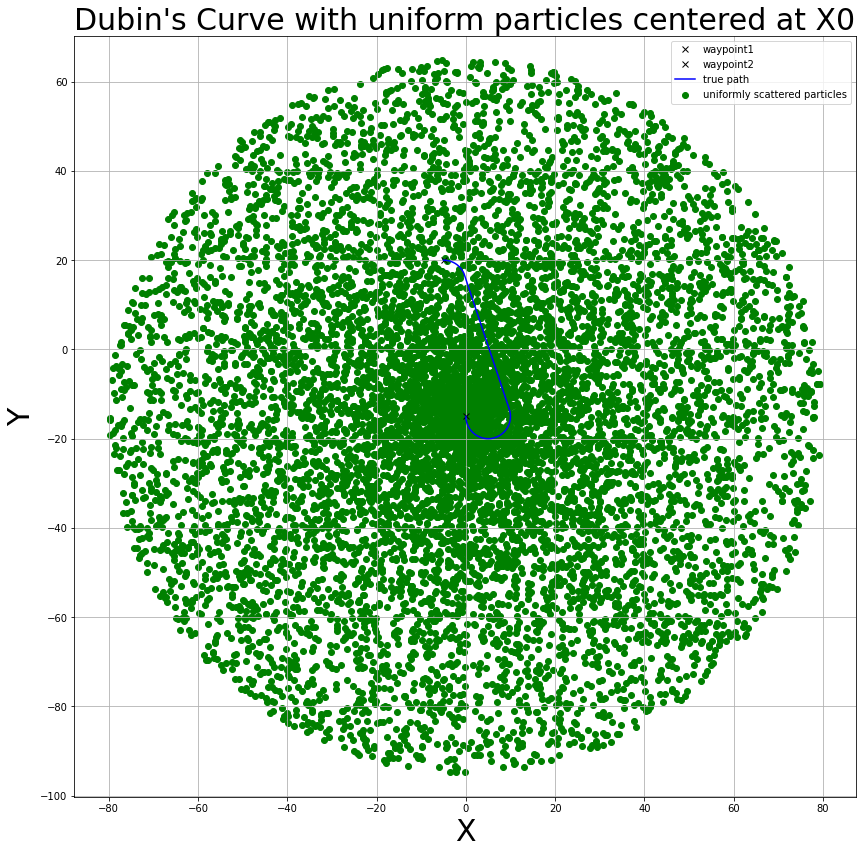

In [6]:
plt.figure(figsize=(14,14))  
plt.plot(Wptz[0].x,Wptz[0].y,'kx')
plt.plot(Wptz[1].x,Wptz[1].y,'kx')
plt.plot(path[:,0],path[:,1],'b-')    
plt.scatter(particles[:,0], particles[:,1], color='g')
#plt.scatter(noised_path_sam1[:,0], noised_path_sam1[:,1], color='r')
#plt.plot(Ekalman_path_intg[:,0], Ekalman_path_intg[:,1], color='c')
#plt.plot(x_Ekalman[:,0], x_Ekalman[:,1], color='c')

plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curve with uniform particles centered at X0', fontsize='30')
plt.xlabel('X', fontsize='30')
plt.ylabel('Y', fontsize='30')
plt.legend(['waypoint1', 'waypoint2','true path', 'uniformly scattered particles'])
plt.show()

def predict(particles, u, std, dt=0.5):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

In [7]:
def predict(particles, u, std, dt=0.5):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist
    
    return particles;

In [8]:
std = [0.01, 0.01]
u = [1/25, 0.5]
weights = np.ones((10000))
weights = weights*wght_init
weights

array([0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001])

In [9]:
def update(particles, weights, y):
    #print(weights.shape)
    for i in range(len(weights)):
        #print("weight: ", weights[i])
        #print("distance: ", z[i])
        weights[i] = norm(scipy.stats.norm.pdf(particles[i,0:2], y[0:2], 5))*weights[i]

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In [10]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

In [11]:
avg, var = estimate(particles, weights)

In [12]:
def m_std(P):
    sum = (P[0,0]**2)+(P[1,1]**2)
    return np.sqrt(sum);

In [13]:
print(avg)
print(var)

[ -0.23497218 -15.07018333]
[1076.04881175 1073.05372844]


In [14]:
particles = predict(particles, u, std)
particles.shape
avg, var = estimate(particles, weights)
print(avg)
print(var)

[ -0.23438437 -15.07337451]
[1075.98218075 1073.10128878]


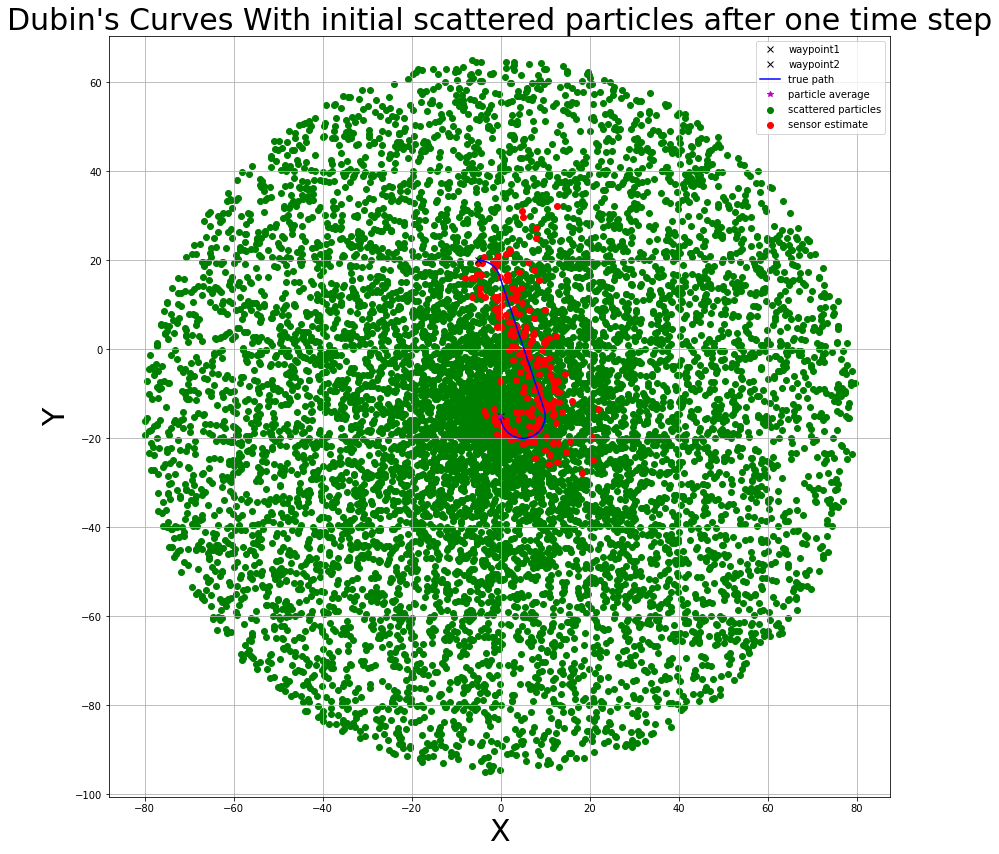

In [15]:
plt.figure(figsize=(14,14))  
plt.plot(Wptz[0].x,Wptz[0].y,'kx')
plt.plot(Wptz[1].x,Wptz[1].y,'kx')
plt.plot(path[:,0],path[:,1],'b-')   

plt.scatter(particles[:,0], particles[:,1], color='g')
plt.plot(avg[0], avg[1], 'm*')
plt.scatter(noised_path_sam1[:,0], noised_path_sam1[:,1], color='r')
#plt.scatter(noised_path_sam1[:,0], noised_path_sam1[:,1], color='r')
#plt.plot(Ekalman_path_intg[:,0], Ekalman_path_intg[:,1], color='c')
#plt.plot(x_Ekalman[:,0], x_Ekalman[:,1], color='c')

plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves With initial scattered particles after one time step', fontsize='30')
plt.xlabel('X', fontsize='30')
plt.ylabel('Y', fontsize='30')
plt.legend(['waypoint1', 'waypoint2','true path', 'particle average', 'scattered particles', 'sensor estimate'])
plt.show()

In [16]:
#a resample parameter used to regenerate if two few main particles
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [17]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [31]:
noised_path_sam1.shape
weights.shape
#zs.shape


(10000,)

In [30]:
x_avg = []
x_avg.append(avg)
zs = np.zeros((N))
P_cov = [var]
for i in range(0,200):
    # distance from robot to each landmark
    #print("measured noisy position: ", noised_path_sam1[i,0:2])
    print("iteration: ", i)
    for j in range(0,N):
        zs[j] = norm(noised_path_sam1[i,0:2] - particles[j,0:2])
        #print(zs[j])
    predict(particles, u=(deg2rad(3), deg2rad(3)), std=(.01, .01))
    #print(zs.shape)
    # incorporate measurements
    update(particles, weights, noised_path_sam1[i,0:2])
    #particles = create_uniform_particles(radius_range, theta_range, deg_range, mu, num_particles)
    #update(particles, weights, noised_path_sam1[i,0:2])
    # resample if too few effective particles
    if neff(weights) < N/2:
        indexes = systematic_resample(weights)
        resample_from_index(particles, weights, indexes)
        assert np.allclose(weights, 1/N)
    mu, var = estimate(particles, weights)
    x_avg.append(mu)
    P_cov.append(var[0])

    
x_avg = np.array(x_avg)
P_cov = np.array(P_cov)
print(x_avg.shape)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
itera

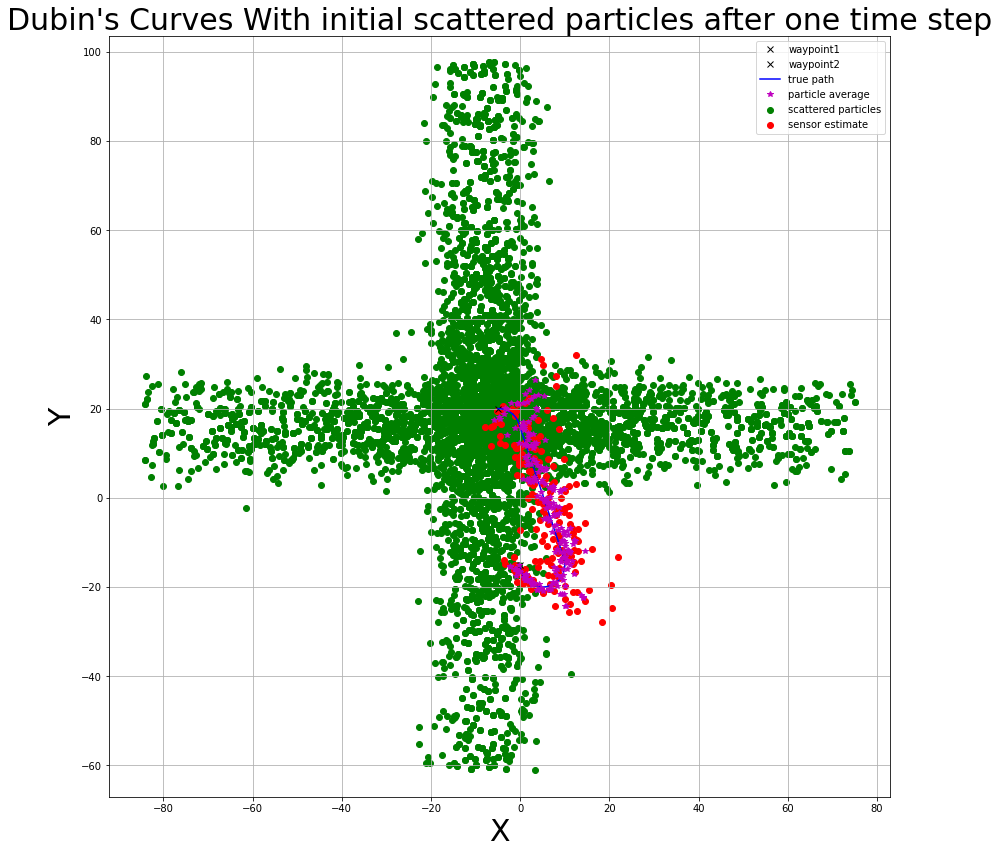

In [28]:
plt.figure(figsize=(14,14))  
plt.plot(Wptz[0].x,Wptz[0].y,'kx')
plt.plot(Wptz[1].x,Wptz[1].y,'kx')
plt.plot(path[:,0],path[:,1],'b-')   

plt.scatter(particles[:,0], particles[:,1], color='g')
plt.plot(x_avg[:,0], x_avg[:, 1], 'm*')
plt.scatter(noised_path_sam1[:,0], noised_path_sam1[:,1], color='r')
#plt.scatter(noised_path_sam1[:,0], noised_path_sam1[:,1], color='r')
#plt.plot(Ekalman_path_intg[:,0], Ekalman_path_intg[:,1], color='c')
#plt.plot(x_Ekalman[:,0], x_Ekalman[:,1], color='c')

plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves With initial scattered particles after one time step', fontsize='30')
plt.xlabel('X', fontsize='30')
plt.ylabel('Y', fontsize='30')
plt.legend(['waypoint1', 'waypoint2','true path', 'particle average', 'scattered particles', 'sensor estimate'])
plt.show()

I don't really seem to have much of an idea what I am doing here, and I was unable to understand the
math from the slides. I have been able to understand the predict and teh estimate steps, but unfortunately
the weights calculation seems to escape me. I think that it is supposed to be proportional to distance, but
but I do not understand how to get the Correct ones. More importantly the rasampling seems to create a 
bunching rapidly that cannot move.